In [140]:
# Time series attempt with Keras

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [141]:
dataset = pd.read_csv ('test1.csv')
df = dataset[dataset['MAC Source']=='00:0c:29:9d:9e:9e']
df['Epoch Time'] = pd.to_datetime(df['Epoch Time'], errors='coerce')
packets_per_sec = df.set_index('Epoch Time').groupby(pd.Grouper(freq='1min'))['Delta Time'].mean()
type(packets_per_sec)
#plt.plot(packets_per_sec.index, packets_per_sec) 
df_small_noise = packets_per_sec[:-1].to_frame().reset_index()
df_small_noise = df_small_noise.fillna(df_small_noise.mean())

<ipython-input-141-1576b33abaa6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Epoch Time'] = pd.to_datetime(df['Epoch Time'], errors='coerce')
<ipython-input-141-1576b33abaa6>:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_small_noise = packets_per_sec[:-1].to_frame().reset_index().fillna(df_small_noise.mean())


In [142]:
dataset = pd.read_csv ('test_mitm1.csv')
df = dataset[dataset['MAC Source']=='00:0c:29:9d:9e:9e']
df['Epoch Time'] = pd.to_datetime(df['Epoch Time'], errors='coerce')
packets_per_sec = df.set_index('Epoch Time').groupby(pd.Grouper(freq='1min'))['Delta Time'].mean()
type(packets_per_sec)
#plt.plot(packets_per_sec.index, packets_per_sec) 
df_daily_jumpsup = packets_per_sec[:-1].to_frame().reset_index()
df_daily_jumpsup = df_daily_jumpsup.fillna(df_daily_jumpsup.mean())
df_daily_jumpsup

<ipython-input-142-6dc9eb9e9187>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Epoch Time'] = pd.to_datetime(df['Epoch Time'], errors='coerce')
<ipython-input-142-6dc9eb9e9187>:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_daily_jumpsup = packets_per_sec[:-1].to_frame().reset_index().fillna(df_small_noise.mean())


,Epoch Time,Delta Time
0,2018-08-25 00:21:00,0.122399
1,2018-08-25 00:22:00,0.127185
2,2018-08-25 00:23:00,0.127480
3,2018-08-25 00:24:00,0.126792
4,2018-08-25 00:25:00,0.128791
...,...,...
355,2018-08-25 06:16:00,0.127813
356,2018-08-25 06:17:00,0.128862
357,2018-08-25 06:18:00,0.129536
358,2018-08-25 06:19:00,0.127782


In [143]:
# training_mean = df_small_noise.mean()
# training_std = df_small_noise.std()
# df_training_value = (df_small_noise - training_mean) / training_std
# print("Number of training samples:", len(df_training_value))
# series_shape = df_small_noise.to_numpy().shape
# np_arr = df_small_noise.to_numpy()
# X = np.expand_dims(np_arr, axis=0).astype('float32')
train, test = train_test_split(df_small_noise, test_size=0.3)
train.shape, test.shape

scaler = StandardScaler()
scaler = scaler.fit(train[['Delta Time']])

train['Delta Time'] = scaler.transform(train[['Delta Time']])
test['Delta Time'] = scaler.transform(test[['Delta Time']])

<ipython-input-143-60135f3d7044>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Delta Time'] = scaler.transform(train[['Delta Time']])
<ipython-input-143-60135f3d7044>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Delta Time'] = scaler.transform(test[['Delta Time']])


In [144]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Delta Time']], train['Delta Time'])
X_test, y_test = create_sequences(test[['Delta Time']], test['Delta Time'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (222, 30, 1)
Testing shape: (78, 30, 1)


In [145]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_23 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_______________________________________________

In [146]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
7/7 [==============================] - 6s 248ms/step - loss: 0.3654 - val_loss: 0.3036
Epoch 2/100
7/7 [==============================] - 1s 83ms/step - loss: 0.3515 - val_loss: 0.3052
Epoch 3/100
7/7 [==============================] - 0s 55ms/step - loss: 0.3491 - val_loss: 0.3005
Epoch 4/100
7/7 [==============================] - 0s 54ms/step - loss: 0.3478 - val_loss: 0.3033
Epoch 5/100
7/7 [==============================] - 0s 56ms/step - loss: 0.3484 - val_loss: 0.3048
Epoch 6/100
7/7 [==============================] - 0s 59ms/step - loss: 0.3467 - val_loss: 0.3068


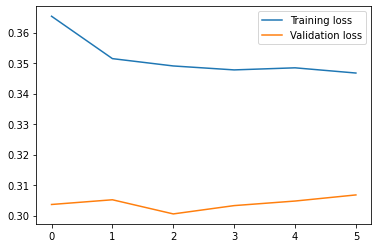

In [147]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [148]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 15ms/step - loss: 0.2938


0.2938356399536133

Reconstruction error threshold: 0.6623009252421465


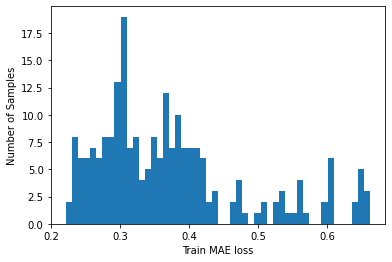

In [149]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')